# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.models.detection import fcos
from torchvision.transforms import v2 as v2
from tqdm.auto import tqdm, trange

import bb
import models
import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

SEED = 325
tt.seed(SEED)

In [3]:
DATA_PATH = Path.home() / "src/data"
CKPT_ROOT = DATA_PATH / "checkpoints"
BATCH_SIZE = 16
TRAIN_PCT = .85
TRANSFORM = v2.Compose(
    [
        # Geometric transforms
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomAffine(
            degrees=5,
            translate=(0.1, 0.1),
            scale=(0.5, 1.5),
            shear=0,
        ),
        v2.RandomPerspective(distortion_scale=0.1, p=0.5),
        # Color transforms
        v2.ColorJitter(
            brightness=0.2,
            contrast=0.2,
            saturation=0.2,
            hue=0.01,
        ),
        # Cleanup after geometric transforms
        v2.ClampBoundingBoxes(),
        v2.SanitizeBoundingBoxes(min_size=10, min_area=100),
    ]
)

MCD_ROOT = DATA_PATH / "coco/minecraft"
MCD = bb.MCDataset(MCD_ROOT)
TRAIN_DSET, VALID_DSET = tt.split1(MCD, TRAIN_PCT, SEED)
TRAIN_DSET = bb.TransformedSubset(TRAIN_DSET, TRANSFORM)

TRAIN_LOADER = DataLoader(
    TRAIN_DSET,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
VAL_LOADER = DataLoader(
    VALID_DSET,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(TRAIN_DSET)}, n_valid={len(VALID_DSET)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62


# Utils

In [4]:
def show_batch_preds(
    trainer: models.FCOSTrainer,
    data_loader: DataLoader,
    k: int = 5,
    thresh: float = 0.5,
) -> Image.Image:
    images, targets = next(iter(data_loader))
    preds = trainer.forward(images)
    lens = [len(p["scores"]) for p in preds]
    print(f"Preds lengths: {lens}")
    preds = trainer.filter_preds(preds, thresh=thresh)
    preds = trainer.topk_preds(preds, k=k)
    return bb.plot_bb_grid(images, preds, AUG_MCD.categories, include_scores=True, nrow=2)

# Experiment Log

## Experiments

### exp1 - classification head only, He init
- cls_head_only_he_init_10ep.pt
- 10 epochs, lr=1e-4
- mAP: 0.0014
- loss looked great, detections terrible

### exp2 - classification head only, FCOS init  
- cls_head_only_fcos_init_8ep.pt
- 10 epochs, lr=1e-4
- mAP: 0.0554
- loss looked worse but 40x better mAP

### exp3 - full head unfrozen, FCOS init
- lr=1e-4
- 10 epochs - mAP: 0.2784 - full_head_10ep.pt
- 20 epochs - mAP: 0.3189 - full_head_20ep.pt
- 40 epochs - mAP: 0.3511 - full_head_40ep.pt
- 50 epochs - mAP: 0.3235 - full_head_50ep.pt
- Much better

### exp4 - full head unfrozen, He init
- mAP - 0.0013
- 10 epochs, lr=1e-4
- Still bad

### exp5 - full head unfrozen, FCOS init, lr=1e-3
- lr=1e-3
- 20 epochs - mAP: 0.3208 - full_head_lr3_20ep.pt
- 40 epochs - mAP: 0.3264 - full_head_lr3_40ep.pt

### Future experiments are all FCOS init

### exp6 - full head unfrozen, aug
 - v2.RandomHorizontalFlip(p=0.5), ColorJitter(brightness=0.2, contrast=0.2),
 - 20 epochs - lr=1e-4 mAP=0.2906 - aug_lr4_20ep.pt
 - 40 epochs - switch to lr=5e-4 loss=0.7192 mAP=0.3307 - aug_lr4_40ep.pt

### exp7 - manually var lr
- lr 1e-3 for 10, lr 1e-4 for 20, lr 5e-5 for 10
- epochs=10 loss=1.0806 mAP=0.2636
- epochs=30 loss=0.8719 mAP=0.3528
- epochs=40 loss=0.7976 mAP=0.3608

### exp8 - ReduceLROnPlateau
- Final epochs=40 loss=0.7257 mAP=0.3546

### exp9 - ReduceLROnPlateau - same with save best
- New best mAP=0.3566 at epoch 31
- Final epochs=60 loss=0.6600 mAP=0.3351

### exp10 - CosineAnnealingWarmRestarts
- T_0=20
- New best mAP=0.3868 at epoch 39
- Final epochs=60 loss=0.8090 mAP=0.3674

### exp11 - CosineAnnealing
- T_max=60
- New best mAP=0.3931 at epoch 54
- Final epochs=60 loss=0.7302 mAP=0.3773

### exp12 - CosineAnnealing, plus nms_thresh=0.2
- T_max=60
- New best mAP=0.3736 at epoch 60
- Epoch 60: val mAP=0.3736 lr=0.000001

### exp13 - like exp12 but added new augmentations
- New best mAP=0.4305 at epoch 57
- Validation was done with transformed images

### exp14 - like exp13 but fixed validation
- New best mAP=0.4132 at epoch 56
- Final epochs=60 loss=1.0941 mAP=0.4000

### exp15 - like exp14 but 100 epochs
- New best mAP=0.4270 at epoch 76
- Messed up scheduler - Left T_max=60

### exp16 - unfreeze feature pyramid network
- New best mAP=0.5952 at epoch 89       * Best

# Experiments

## Exp 1

In [ ]:
he_init_ckpt = CKPT_ROOT / f"cls_head_only_he_init_{NUM_EPOCHS}ep.pt"

# e_he_init = models.FCOSTrainer(categories=mcd.categories, he_init=True)
# e_he_init.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# e_he_init.save_checkpoint(he_init_ckpt)

# e_he_init = models.FCOSTrainer(
#     categories=mcd.categories, he_init=True, checkpoint=he_init_ckpt
# )

## Exp 2

In [ ]:
fcos_init_ckpt = CKPT_ROOT / f"cls_head_only_fcos_init_{NUM_EPOCHS}ep.pt"

# e_fcos_init = models.FCOSTrainer(categories=mcd.categories, he_init=False)
# e_fcos_init.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# e_fcos_init.save_checkpoint(fcos_init_ckpt)

# e_fcos_init = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=fcos_init_ckpt
# )

## Exp 3

In [ ]:
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, he_init=False)
START_CKPT = CKPT_ROOT / f"full_head_40ep.pt"
END_CKPT = CKPT_ROOT / f"full_head_50ep.pt"

# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(CKPT)

TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=START_CKPT
)
TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=10)
TRAINER.save_checkpoint(END_CKPT)

# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
TRAINER.plot_loss(label="Exp 3")
TRAINER.plot_eval(label="Exp 3")

In [ ]:
epoch_range = (30, None)
TRAINER.plot_loss(epoch_range=epoch_range, show=True)
TRAINER.plot_eval(epoch_range=epoch_range)

## Exp 5

In [ ]:
start_epoch = 20
end_epoch = 40
NUM_EPOCHS = end_epoch - start_epoch
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, he_init=False)
START_CKPT = CKPT_ROOT / f"full_head_lr3_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"full_head_lr3_{end_epoch}ep.pt"

# Train new
# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=START_CKPT
# )
# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=END_CKPT
)
TRAINER.plot_loss(label="Exp 5")
TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, VAL_LOADER, k=5)

In [ ]:
epoch_range = (-20, None)
TRAINER.plot_loss(epoch_range=epoch_range, show=True)
TRAINER.plot_eval(epoch_range=epoch_range)

## Exp 6

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 20
end_epoch = 40
LR = 1e-4
epoch_prefix = "aug_lr4"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None
# bb.plot_bb_grid(images, targets, mcd.categories)

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, he_init=False, lr=LR)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
LR = 5e-5
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=START_CKPT, lr=LR
)
TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
TRAINER.save_checkpoint(END_CKPT)

# Load and plot
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
# TRAINER.plot_loss(label="Exp 5")
# TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, aug_val_loader, k=5)

## Exp 7

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 30
end_epoch = 40
epoch_prefix = "exp7"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# LR = 1e-3
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, he_init=False, lr=LR)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# LR = 1e-4
LR = 5e-5
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, he_init=False, load_checkpoint=START_CKPT, lr=LR
)
TRAINER.train(
    train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
)
TRAINER.save_checkpoint(END_CKPT)

# Load and plot
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
# TRAINER.plot_loss(label="Exp 5")
# TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, aug_val_loader, k=1)

## Exp 8

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 40
end_epoch = 60
epoch_prefix = "exp8"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"
BEST_CKPT = CKPT_ROOT / f"{epoch_prefix}_best.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=START_CKPT)
# TRAINER.train(
#     train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
# )
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, load_checkpoint=END_CKPT)
TRAINER.plot_loss(label="Exp 8", show=True)
TRAINER.plot_eval(label="Exp 8")

## Exp9

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

start_epoch = 0
end_epoch = 60
epoch_prefix = "exp9"

NUM_EPOCHS = end_epoch - start_epoch
START_CKPT = CKPT_ROOT / f"{epoch_prefix}_{start_epoch}ep.pt"
END_CKPT = CKPT_ROOT / f"{epoch_prefix}_{end_epoch}ep.pt"
BEST_CKPT = CKPT_ROOT / f"{epoch_prefix}_best.pt"

aug_mcd = bb.MCDataset(MCD_ROOT, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(AUG_MCD, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, best_checkpoint=BEST_CKPT)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=START_CKPT, best_checkpoint=BEST_CKPT)
# TRAINER.train(
#     train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
# )
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(categories=AUG_MCD.categories, load_checkpoint=END_CKPT)
TRAINER.plot_loss(label=epoch_prefix, show=True)
TRAINER.plot_eval(label=epoch_prefix)

In [ ]:

# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
trainer = models.FCOSTrainer(categories=AUG_MCD.categories, load_checkpoint=BEST_CKPT)
show_batch_preds(trainer, VAL_LOADER, k=1)

## Exp10

In [ ]:
project = "exp10"
num_epochs = 60
load_chkpt = "best.pt"

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, project_dir=project_dir, load_checkpoint=load_chkpt
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)

## Exp11

In [ ]:
project = "exp11"
num_epochs = 60
load_chkpt = "best.pt"

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories, project_dir=project_dir, load_checkpoint=load_chkpt
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)

## Exp12

In [ ]:
project = "exp12"
num_epochs = 60
load_chkpt = None

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=AUG_MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
TRAINER.save_checkpoint()

# Plot
# TRAINER.plot_loss(label=project, show=True)
# TRAINER.plot_eval(label=project, show=True)
# TRAINER.plot_lr(label=project)

## Exp13

In [ ]:
project = "exp13"
num_epochs = 60
load_chkpt = "best.pt"

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)

In [ ]:
TRAINER.evaluate(VAL_LOADER)

## Exp14

In [ ]:
project = "exp14"
num_epochs = 60
load_chkpt = None

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
TRAINER.save_checkpoint()

# Plot
# TRAINER.plot_loss(label=project, show=True)
# TRAINER.plot_eval(label=project, show=True)
# TRAINER.plot_lr(label=project)

## Exp15

In [ ]:
project = "exp15"
num_epochs = 100
load_chkpt = "best.pt"

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.5,
    # score_thresh=0.2,
    nms_thresh=0.4,
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)

## Exp16

Loading checkpoint: /Users/joe/src/data/checkpoints/exp16/best.pt
err_keys = <All keys matched successfully>


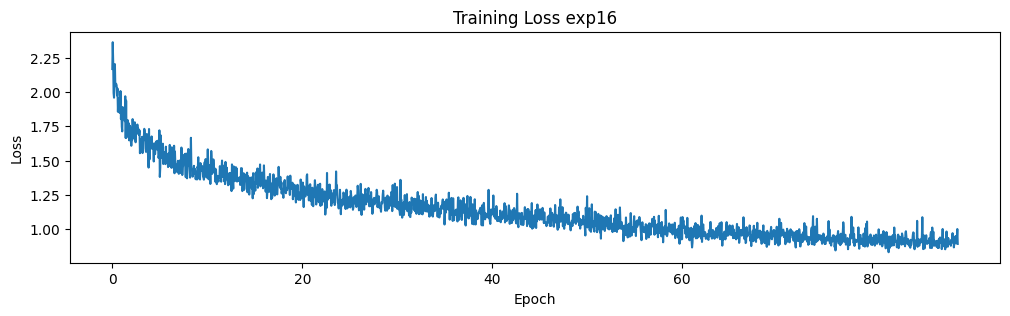

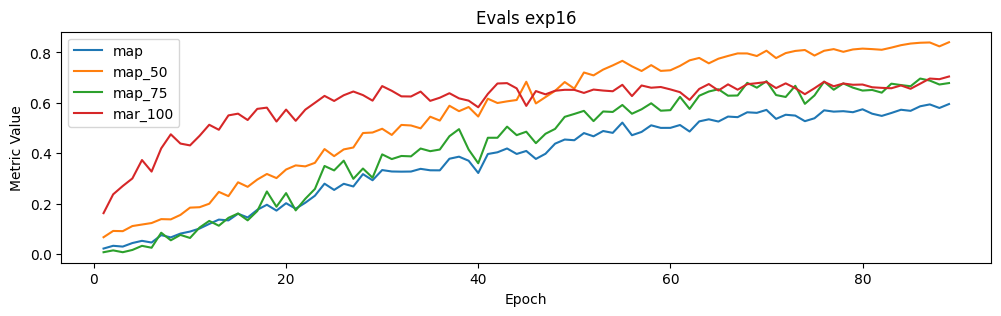

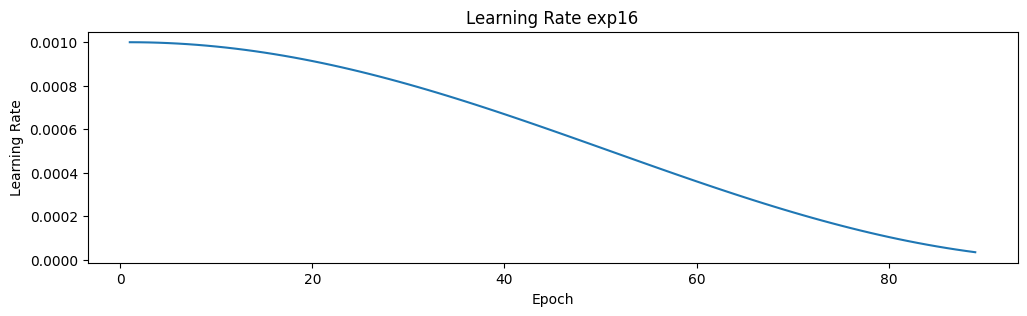

In [5]:
project = "exp16"
num_epochs = 100
load_chkpt = "best.pt"
# XXX Set T_max for LR scheduler to num_epochs

project_dir = CKPT_ROOT / project
TRAINER = models.FCOSTrainer(
    categories=MCD.categories,
    project_dir=project_dir,
    load_checkpoint=load_chkpt,
    score_thresh=0.5,       # test
    # score_thresh=0.2,     # train
    nms_thresh=0.4,
)

# Train
# TRAINER.train(train_loader=TRAIN_LOADER, val_loader=VAL_LOADER, num_epochs=num_epochs)
# TRAINER.save_checkpoint()

# Plot
TRAINER.plot_loss(label=project, show=True)
TRAINER.plot_eval(label=project, show=True)
TRAINER.plot_lr(label=project)


# Scratch

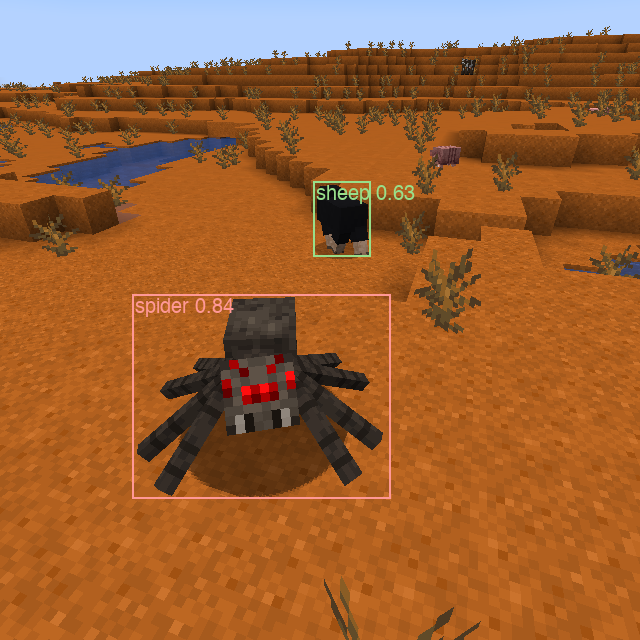

In [6]:
img_ix = 0
TRAINER.plot_infer(VALID_DSET[img_ix][0], topk=5)

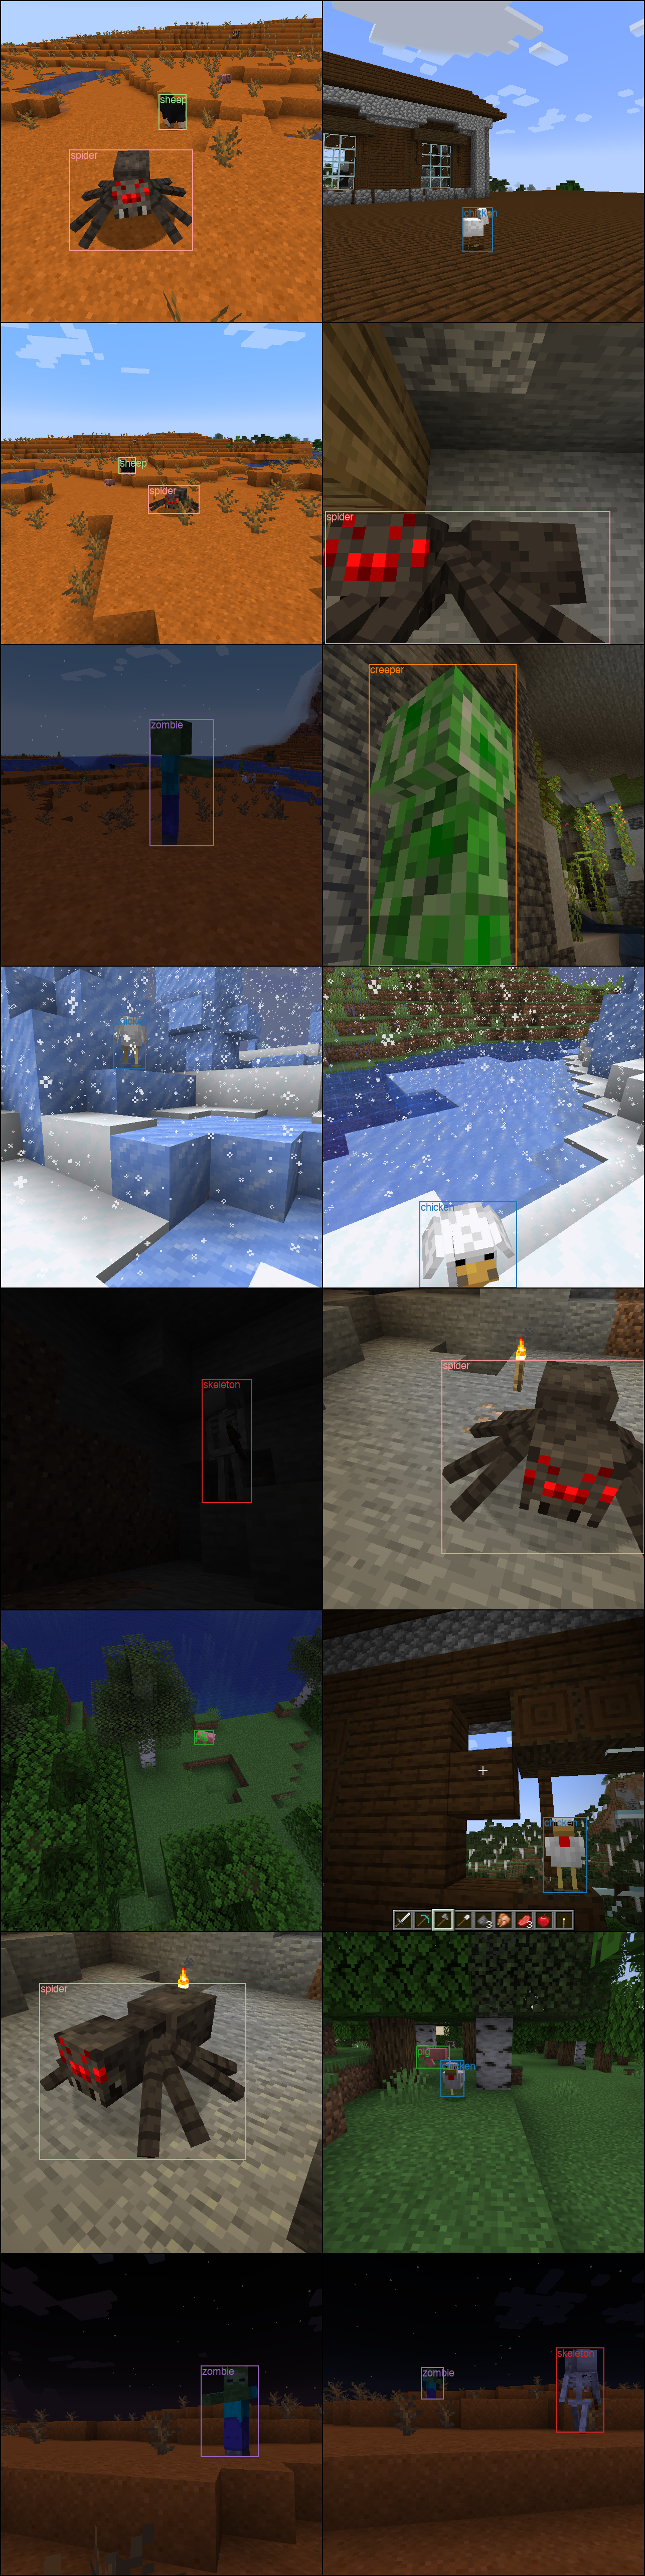

In [7]:
images, targets = next(iter(VAL_LOADER))
# images, targets = next(iter(TRAIN_LOADER))
bb.plot_bb_grid(images, targets, MCD.categories, nrow=2)

In [ ]:
show_batch_preds(TRAINER, VAL_LOADER, k=5)

# Augmentation tests

In [ ]:
transform = v2.Compose(
    [
        # Geometric transforms
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomAffine(
            degrees=5,
            translate=(0.1, 0.1),
            scale=(0.5, 1.5),
            shear=0,
        ),
        v2.RandomPerspective(distortion_scale=0.1, p=0.5),
        # Color transforms
        v2.ColorJitter(
            brightness=0.4,
            contrast=0.2,
            saturation=0.7,
            hue=0.01,
        ),
        # Cleanup after geometric transforms
        v2.ClampBoundingBoxes(),
        v2.SanitizeBoundingBoxes(min_size=1),
    ]
)

In [ ]:
image, target = MCD[0]

# Apply to image and boxes together
image, target = transform(image, target)
print(image.shape)
# Fv2.to_pil_image(image)
bb.torch_plot_bb(image, target, categories=MCD.categories, return_pil=True)